## Plot gene set comparison

In this notebook, we want to compare prediction of mutations in the genes from our cancer gene set, derived from [Vogelstein et al. 2013](https://science.sciencemag.org/content/339/6127/1546), with two other sets of potentially relevant genes. These are:

* The most frequently mutated genes in TCGA
* A set of random genes in TCGA, that meet our mutation count threshold for 2 or more cancer types
 
We selected enough genes in each of these gene sets to match the count of the Vogelstein et al. gene set.
 
In these experiments we only used gene expression data, and we used the set of TCGA samples that have both gene expression and MC3 somatic mutation data. The files analyzed in this notebook were generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)
* PLOT_AUROC (bool): if True plot AUROC, else plot AUPR

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# set results directory
vogelstein_results_dir = Path(cfg.results_dirs['mutation'],
                              'shuffle_cancer_type',
                              'expression_vogelstein',
                              'gene').resolve()
top_50_results_dir = Path(cfg.results_dirs['mutation'],
                          'shuffle_cancer_type',
                          'expression_top',
                          'gene').resolve()
random_50_results_dir = Path(cfg.results_dirs['mutation'],
                             'shuffle_cancer_type',
                             'expression_random',
                             'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = True

# if True, plot AUROC instead of AUPR
PLOT_AUROC = False
if PLOT_AUROC:
    plot_metric = 'auroc'
    images_dir = Path(cfg.images_dirs['mutation'], 'auroc')
else:
    plot_metric = 'aupr'
    images_dir = Path(cfg.images_dirs['mutation'])

In [3]:
# load raw data
vogelstein_df = au.load_stratified_prediction_results(vogelstein_results_dir, 'gene')
vogelstein_df = vogelstein_df[vogelstein_df.training_data.isin(['expression'])]
vogelstein_df['gene_set'] = 'vogelstein'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(vogelstein_df.shape)
print(vogelstein_df.seed.unique())
print(vogelstein_df.training_data.unique())
vogelstein_df.head()

(4080, 10)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.99980,0.99808,MAP3K1,expression,signal,42,train,0,gene,vogelstein
1,0.75084,0.43962,MAP3K1,expression,signal,42,test,0,gene,vogelstein
2,0.68143,0.30787,MAP3K1,expression,signal,42,cv,0,gene,vogelstein
3,0.99999,0.99989,MAP3K1,expression,signal,42,train,1,gene,vogelstein
4,0.66563,0.43830,MAP3K1,expression,signal,42,test,1,gene,vogelstein


In [4]:
# load raw data
top_50_df = au.load_stratified_prediction_results(top_50_results_dir, 'gene')
top_50_df = top_50_df[top_50_df.training_data.isin(['expression'])]
top_50_df['gene_set'] = 'top_50'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(top_50_df.shape)
print(top_50_df.seed.unique())
print(top_50_df.training_data.unique())
top_50_df.head()

(4080, 10)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.74794,0.73366,TP53,expression,shuffled,42,train,0,gene,top_50
1,0.72432,0.70529,TP53,expression,shuffled,42,test,0,gene,top_50
2,0.62036,0.58252,TP53,expression,shuffled,42,cv,0,gene,top_50
3,0.74560,0.72252,TP53,expression,shuffled,42,train,1,gene,top_50
4,0.71529,0.68845,TP53,expression,shuffled,42,test,1,gene,top_50


In [5]:
# load raw data
random_50_df = au.load_stratified_prediction_results(random_50_results_dir, 'gene')
random_50_df = random_50_df[random_50_df.training_data.isin(['expression'])]
random_50_df['gene_set'] = 'random_50'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(random_50_df.shape)
print(random_50_df.seed.unique())
print(random_50_df.training_data.unique())
random_50_df.head()

(4080, 10)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.74794,0.73366,TP53,expression,shuffled,42,train,0,gene,random_50
1,0.72432,0.70529,TP53,expression,shuffled,42,test,0,gene,random_50
2,0.62036,0.58252,TP53,expression,shuffled,42,cv,0,gene,random_50
3,0.74560,0.72252,TP53,expression,shuffled,42,train,1,gene,random_50
4,0.71529,0.68845,TP53,expression,shuffled,42,test,1,gene,random_50


In [6]:
# combine results dataframes
results_df = (
    pd.concat((vogelstein_df, top_50_df, random_50_df))
      .drop(columns=['training_data', 'experiment'])
      .rename(columns={'gene_set': 'training_data'})
)

all_results_df = au.compare_all_data_types(results_df,
                                           SIG_ALPHA,
                                           filter_genes=False,
                                           metric=plot_metric)

all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)
all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
25,ERBB2,0.577879,2.124069e-09,6.268628e-08,True,vogelstein,7.202828
82,TP53,0.215245,2.398908e-09,6.268628e-08,True,vogelstein,7.202828
77,TP53,0.215245,2.398908e-09,2.039071e-07,True,top_50,6.690568
77,TP53,0.215245,2.398908e-09,1.157495e-07,True,random_50,6.936481
70,RB1,0.321806,2.723517e-09,6.268628e-08,True,vogelstein,7.202828
67,RB1,0.321806,2.723517e-09,1.157495e-07,True,random_50,6.936481
23,EGFR,0.569015,2.949943e-09,6.268628e-08,True,vogelstein,7.202828
27,CTNNB1,0.524670,1.900094e-08,5.383599e-07,True,random_50,6.268927
21,CTNNB1,0.524670,1.900094e-08,3.189325e-07,True,vogelstein,6.496301
17,CDKN2A,0.269531,2.251288e-08,3.189325e-07,True,vogelstein,6.496301


random: 9/85
most mutated: 7/85
Vogelstein et al.: 45/85


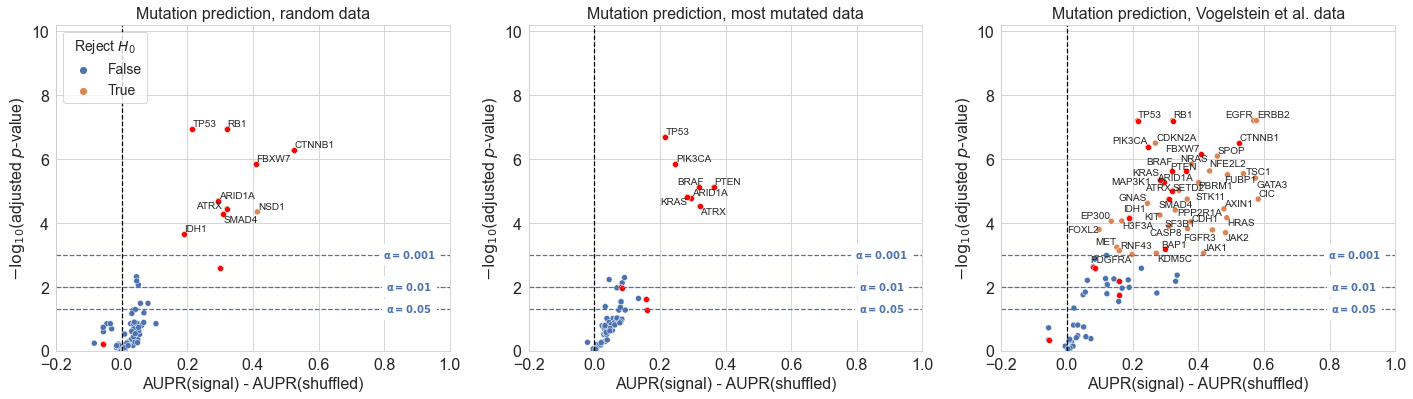

In [7]:
sns.set({'figure.figsize': (24, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

gene_set_map = {
    'random_50': 'random',
    'top_50': 'most mutated',
    'vogelstein': 'Vogelstein et al.'
}
all_results_df.training_data.replace(to_replace=gene_set_map, inplace=True)

plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          gene_set_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True,
                          color_overlap=True)

if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'expression_vs_shuffled.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'expression_vs_shuffled.png',
                dpi=300, bbox_inches='tight')

Vogelstein et al.: 45/85


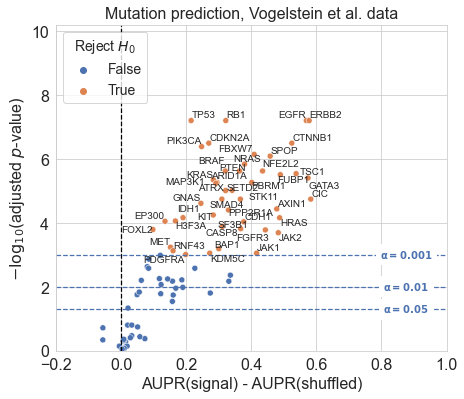

In [8]:
sns.set({'figure.figsize': (7, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 1)

gene_set_map = {
    'vogelstein': 'Vogelstein et al.'
}
all_results_df.training_data.replace(to_replace=gene_set_map, inplace=True)

plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          gene_set_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True)

if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'expression_vogelstein.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'expression_vogelstein.png',
                dpi=300, bbox_inches='tight')

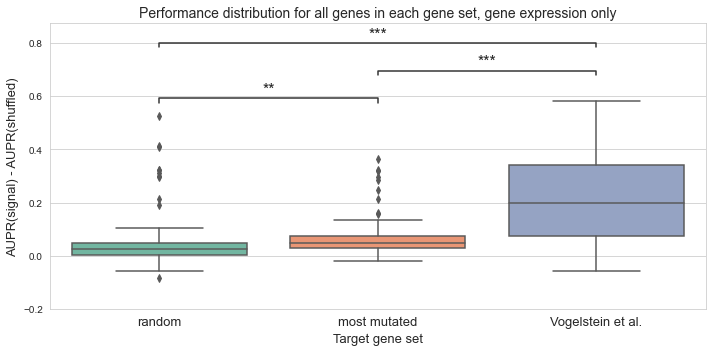

In [9]:
sns.set({'figure.figsize': (10, 5)})
sns.set_style('whitegrid')
# we want these colors to be different than the expression/methylation ones
sns.set_palette('Set2')
fig, axarr = plt.subplots(1, 1)


gene_set_map = {
    'random_50': 'random',
    'top_50': 'most mutated',
    'vogelstein': 'Vogelstein et al.'
}

all_results_df = (all_results_df
   .rename(columns={'training_data': 'gene_set'})
   .sort_values(by='gene_set', ascending=False)
)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr
sns.boxplot(data=all_results_df, x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Performance distribution for all genes in each gene set, gene expression only', size=14)
ax.set_xlabel('Target gene set', size=13)
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()),
              size=13)
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))
for tick in ax.get_xticklabels():
    tick.set_fontsize(13)
    
plt.tight_layout()

tests_df = plu.add_annotation(ax,
                              all_results_df.rename(
                                  columns={'gene_set': 'training_data'}
                              ),
                              all_pairs=(gene_set_map.values()),
                              metric=plot_metric,
                              box_pairs=[('random', 'most mutated'),
                                         ('most mutated', 'Vogelstein et al.'),
                                         ('random', 'Vogelstein et al.')])

if SAVE_FIGS:
    plt.savefig(images_dir / 'expression_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'expression_boxes.png',
                dpi=300, bbox_inches='tight')

In [10]:
# pairwise rank sum tests comparing results distributions
# H0: results distributions are the same between the data types
tests_df.sort_values('p_value')

,data_type_1,data_type_2,p_value,corr_pval,reject_null
1,random,Vogelstein et al.,6.945213e-10,2.083564e-09,True
2,most mutated,Vogelstein et al.,1.237451e-09,3.712353e-09,True
0,random,most mutated,2.667195e-03,8.001585e-03,True


(46,)
['CTNNB1' 'FBXW7' 'ATRX' 'ARID1A' 'RB1' 'SMAD4' 'TP53' 'IDH1' 'NSD1'
 'PIK3CA' 'PTEN' 'KRAS' 'BRAF' 'EGFR' 'EP300' 'ERBB2' 'FGFR3' 'GATA3'
 'FOXL2' 'FUBP1' 'GNAS' 'H3F3A' 'HRAS' 'AXIN1' 'BAP1' 'CASP8' 'CDH1'
 'CDKN2A' 'CIC' 'PDGFRA' 'JAK1' 'PPP2R1A' 'RNF43' 'SETD2' 'SF3B1' 'JAK2'
 'SPOP' 'STK11' 'TSC1' 'PBRM1' 'NRAS' 'KDM5C' 'KIT' 'MAP3K1' 'MET'
 'NFE2L2']


(-0.2, 0.6328050000000001)

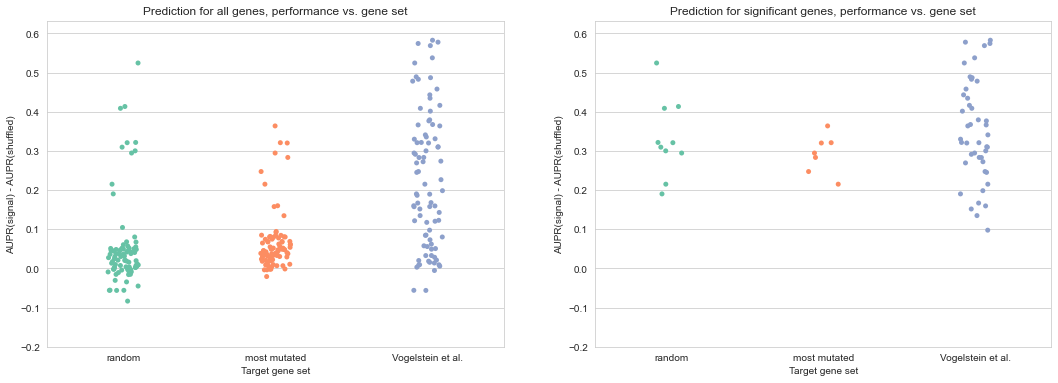

In [11]:
sns.set({'figure.figsize': (18, 6)})
sns.set_style('whitegrid')
# we want these colors to be different than the expression/methylation ones
sns.set_palette('Set2')
fig, axarr = plt.subplots(1, 2)

all_results_df.replace({'gene_set': gene_set_map}, inplace=True)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0]
sns.stripplot(data=all_results_df, x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Prediction for all genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

# plot mean performance for genes that are significant for at least one data type
ax = axarr[1]
gene_list = all_results_df[all_results_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.stripplot(data=all_results_df[all_results_df.gene.isin(gene_list)],
              x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Prediction for significant genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

### Calculate gene set overlap
 
Of the significantly predictable genes in the top/random gene sets, how many of them are in the Vogelstein gene set?

random 85
most mutated 85
Vogelstein et al. 85


Text(0.5, 1.0, 'Gene overlap between all genes in gene set')

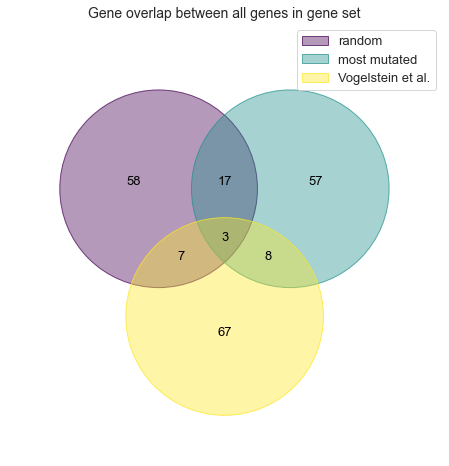

In [12]:
from venn import venn

# first look at overlap of all genes
genes_in_gene_set = {}
for gene_set in all_results_df.gene_set.unique():
    gene_list = all_results_df[all_results_df.gene_set == gene_set].gene.unique()
    print(gene_set, len(gene_list))
    genes_in_gene_set[gene_set] = set(gene_list)

venn(genes_in_gene_set)
plt.title('Gene overlap between all genes in gene set', size=14)

random 9
most mutated 7
Vogelstein et al. 45


Text(0.5, 1.0, 'Gene overlap between significantly predictable genes in gene set')

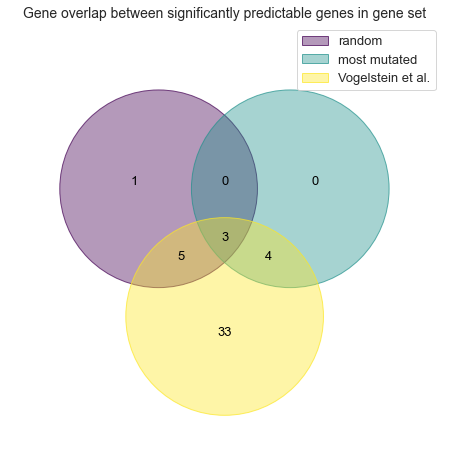

In [13]:
# now look at overlap of significant genes
genes_in_gene_set = {}
for gene_set in all_results_df.gene_set.unique():
    gene_list = all_results_df[(all_results_df.gene_set == gene_set) &
                               (all_results_df.reject_null)].gene.unique()
    print(gene_set, len(gene_list))
    genes_in_gene_set[gene_set] = set(gene_list)

venn(genes_in_gene_set)
plt.title('Gene overlap between significantly predictable genes in gene set', size=14)